In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from resizeimage import resizeimage
import warnings
warnings.filterwarnings('ignore')
from qiskit.aqua.circuits.fourier_transform_circuits import FourierTransformCircuits

In [2]:
import frqi                                                                     
import quantum_edge_detection as qed

Using TensorFlow backend.


In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-university", group="columbia-univers", project="comse-6998-2020")

In [4]:
# To store account info
#from qiskit import IBMQ
#IBMQ.save_account('d6b8341cf93840fcc1102abcda046ffed464d0d10c968ea9ebcedcb76044fe3732c7bed54e2b697fd4c8f8ed42676775f341d05509d59c157a7ebd410630e6c2')

In [5]:
anc = QuantumRegister(1, "anc")
img = QuantumRegister(11, "img")
anc2 = QuantumRegister(1, "anc2")
c = ClassicalRegister(12)

qc = QuantumCircuit(anc, img, anc2, c)

imageNames = ["Pic.jpg","Original 640x426/Tokyo - ISS030-E-82770.JPG", "Original 640x426/Osaka - ISS030-E-184140.JPG", "Original 640x426/Nagoya - ISS038-E-11205.JPG"]
imageNum1 = 0
#imageNum2 = 2

image2 = Image.open(imageNames[imageNum1])
image2.thumbnail([32,32])
image2.save("img_small.jpeg", "JPEG")
image1 = Image.open(imageNames[imageNum1]).convert('LA')
#image2 = Image.open(imageNames[imageNum2]).convert('LA')

def image_normalization(image):
    image = resizeimage.resize_cover(image, [32, 32])
    w, h = 32, 32
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image = np.arcsin(image)

    return generated_image

image1 = image_normalization(image1)
#image2 = image_normalization(image2)

In [6]:
# apply hadamard gates
for i in range(1, len(img)):
    qc.h(img[i])

# encode ref image
for i in range(len(image1)):
        if image1[i] != 0:
                frqi.c10mary(qc, 2 * image1[i], format(i, '010b'), img[0], anc2[0], [img[j] for j in range(1,len(img))])

#qed.quantum_edge_detection(qc)
#FourierTransformCircuits.construct_circuit(qc, qc.qubits)
qc.measure(anc, c[0])
qc.measure(img, c[1:12])
print(qc.depth())
numOfShots = 8192
result = execute(qc, provider.get_backend('ibmq_qasm_simulator'), shots=numOfShots, backend_options={"fusion_enable":True}).result()


72192


In [ ]:
#circuit_drawer(qc).show()

In [ ]:
#plot_histogram(result.get_counts(qc))

In [ ]:
#print(result.get_counts(qc))

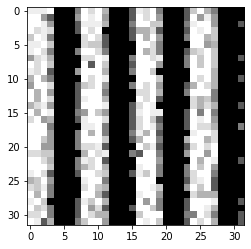

In [7]:
# generated image
genimg = np.array([])

#### decode
for i in range(len(image1)):
        try:
                genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'10']/numOfShots)])
        except KeyError:
                genimg = np.append(genimg,[0.0])

#genimg = np.log(np.abs(genimg))
# inverse nomalization
genimg *= 32.0 * 255.0

# convert type
genimg = genimg.astype('int')

# back to 2-dimentional data
genimg = genimg.reshape((32,32))

plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
plt.savefig('gen_'+str(imageNum1)+'.png')
plt.show()

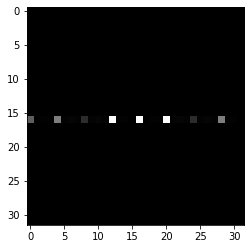

In [32]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2
fft_new = fftshift(fft2(image1.reshape(32,32)))
img_ff = np.abs(fft_new)
plt.imshow(img_ff, cmap='gray', vmin=0, vmax=255)
#plt.savefig('gen_'+str(imageNum1)+'.png')
plt.show()

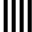

In [25]:
from IPython.display import Image as show_img
show_img(filename='img_small.jpeg') 